# 2020-09-18 • Clip spikes before STA

This notebook is similar to {doc}`/notebooks/2020-07-29__STA` and {doc}`/notebooks/2020-09-10__STA_for_different_PSP_shapes`.\

We still wonder whether the bump in the STA is due to averaging post synaptic potentials (PSPs), or postsynaptic spikes.

Here, we try to remove the influence of spikes in the STA by clipping them before averaging windows.

## Reproducibility

In [1]:
%reload_ext watermark
%watermark -ntz -v -hm -rgb -iv

Fri Sep 18 2020 16:08:54 GMT Daylight Time 

CPython 3.8.3
IPython 7.13.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit
host name  : LABTOP
Git hash   : 5c2958efe77ec99f89399e38845283c44798eadc
Git repo   : git@github.com:tfiers/voltage-to-wiring-sim.git
Git branch : main


## Nothing new here

All sections nested under this are the same as in the two previous notebooks.

### Imports & time grid

In [2]:
from voltage_to_wiring_sim.notebook_init import *

Preloading:
 - numpy … (0.20 s)
 - matplotlib.pyplot … (0.35 s)
 - numba … (0.68 s)
 - sympy … (0.89 s)
 - unyt … (3.99 s)

Imported `np`, `mpl`, `plt
Imported package `voltage_to_wiring_sim` as `v`
Imported `*` from `v.util` and from `v.units`
Setup autoreload

Reproducibility info. This notebook was last run on/with:

Fri Sep 18 2020 16:09:01 GMT Daylight Time 

CPython 3.8.3
IPython 7.13.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit
host name  : LABTOP
Git hash   : 5c2958efe77ec99f89399e38845283c44798eadc
Git repo   : git@github.com:tfiers/voltage-to-wiring-sim.git
Git branch : main



In [3]:
tg = v.TimeGrid(T=10 * minute, dt=0.1 * ms)

TimeGrid(T=Quantity(10 min, stored in s, float64), dt=Quantity(0.1 ms, stored in s, float64), N=unyt_quantity(6000000, '(dimensionless)'), t=Array([0 1.667E-06 3.333E-06 ... 10 10 10] min, stored in s, float64))

### Spike trains

'Network' definition.

In [4]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

Have all incoming neurons spike with the same mean frequency, for now.

In [5]:
f_spike = 20 * Hz

Quantity(20 Hz, stored in Hz, float64)

In [6]:
gen_st = v.generate_Poisson_spike_train

fix_rng_seed()

In [7]:
%%time
spike_trains_connected = [gen_st(tg, f_spike) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(tg, f_spike) for _ in range(N_unconnected)]

Wall time: 5.26 s


In [8]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected;

Inspect a time excerpt..

In [9]:
time_slice = 1 * minute + [0, 1] * second

slice_indices = np.round(time_slice / tg.dt).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.t[i_slice].in_units(second);

..of one presynaptic neuron:


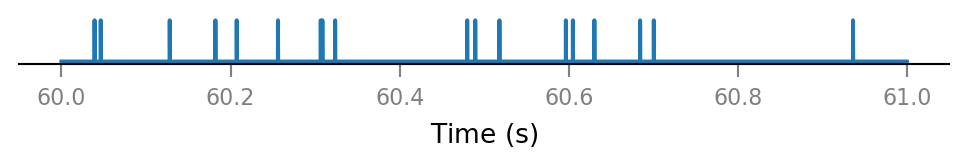

In [10]:
v.spike_train.plot(t_slice, all_spike_trains[0][i_slice]);

All connected presynaptic neurons:

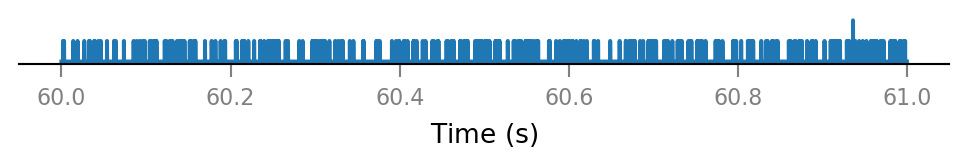

In [11]:
all_incoming_spikes = sum(spike_trains_connected)

v.spike_train.plot(t_slice, all_incoming_spikes[i_slice]);

### Synaptic conductance

In [12]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms;

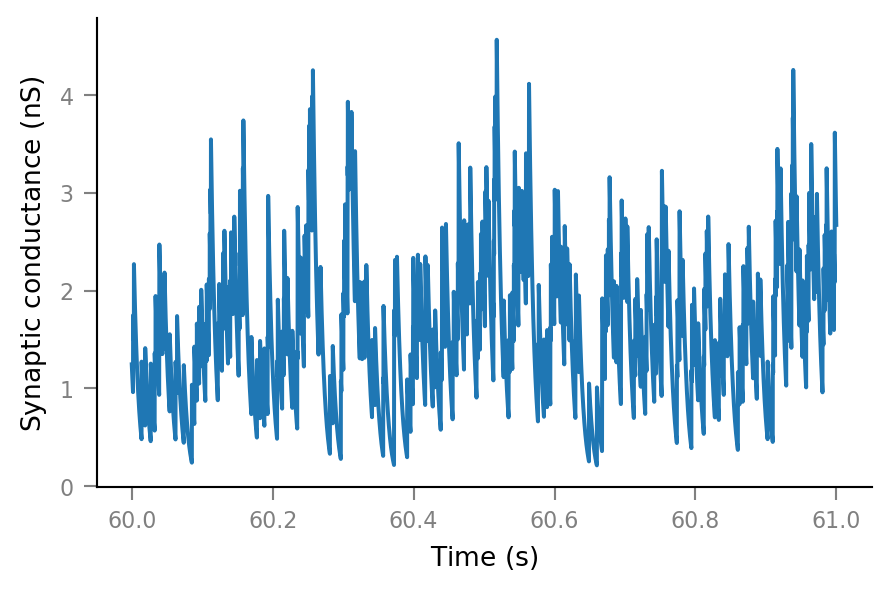

In [13]:
g_syn = v.calc_synaptic_conductance(tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice]);

### Membrane voltage

In [14]:
params = v.params.cortical_RS
print(params)

IzhikevichParams
----------------
C = 100 pF
k = 0.7 nS/mV
v_r = -60 mV
v_t = -40 mV
v_peak = 35 mV
a = 0.03 1/ms
b = -2 nS
c = -50 mV
d = 100 pA
v_syn = 0 mV


In [15]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 1.05 s


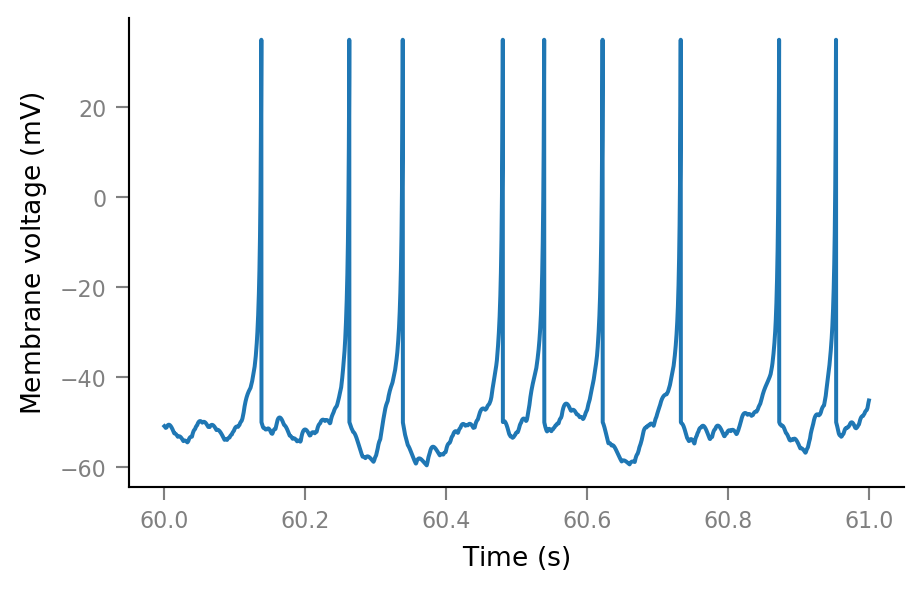

In [16]:
plt.plot(t_slice, sim.V_m[i_slice]);

### Noise

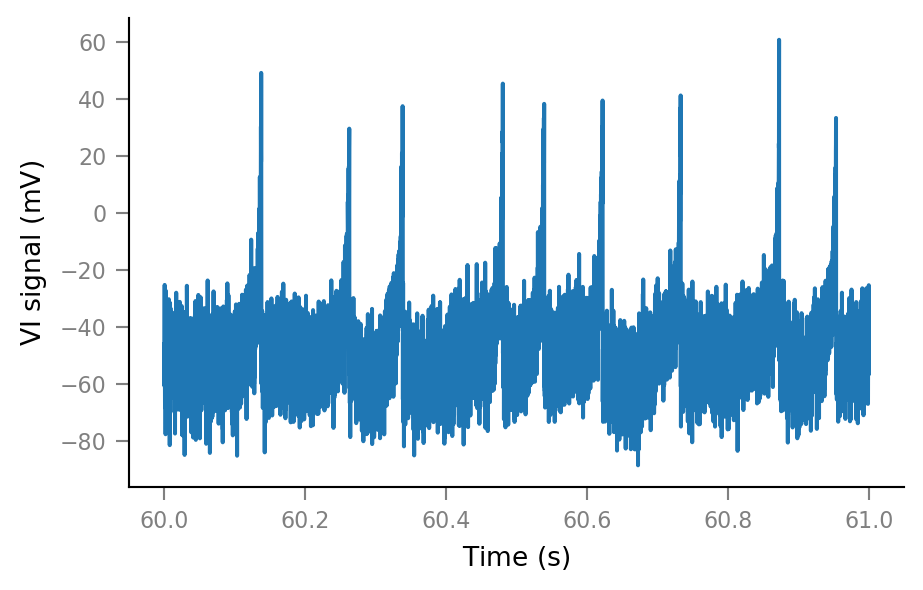

In [17]:
SNR = 10
spike_height = params.v_peak - params.v_r

σ_noise = spike_height / SNR
noise = np.random.randn(tg.N) * σ_noise

Vm_noisy = (sim.V_m + noise).in_units(mV)
Vm_noisy.name = "VI signal"

plt.plot(t_slice, Vm_noisy[i_slice]);

## Clip spikes

In [18]:
import seaborn as sns

Wall time: 41.8 s


Text(0.5, 0, 'VI signal (mV)')

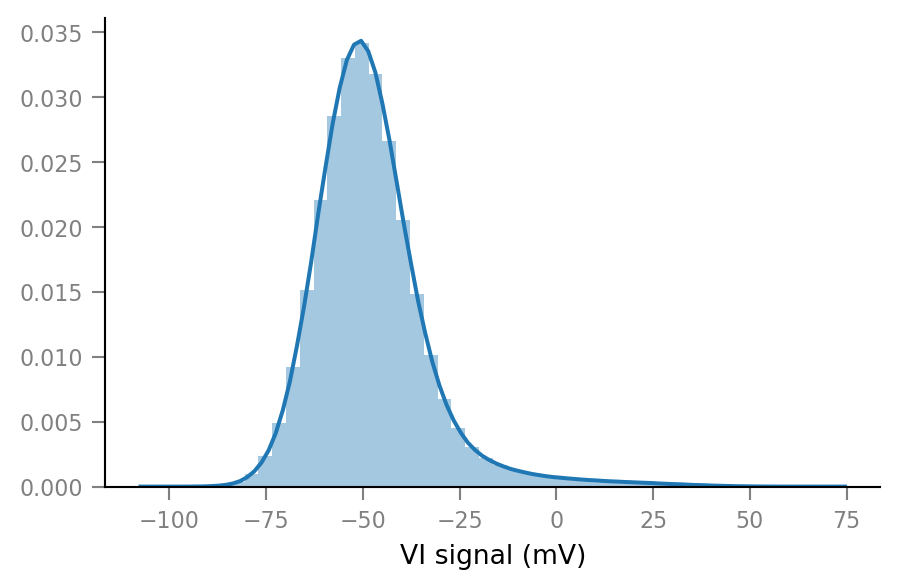

In [19]:
%%time
ax = sns.distplot(np.array(Vm_noisy.in_display_units))
ax.set_xlabel("VI signal (mV)");

We'll arbitrarily put a threshold here:

In [26]:
clip_threshold = -20 * mV;

In [27]:
Vm_noisy_clipped = np.clip(Vm_noisy, a_min=None, a_max= clip_threshold).in_units(mV);

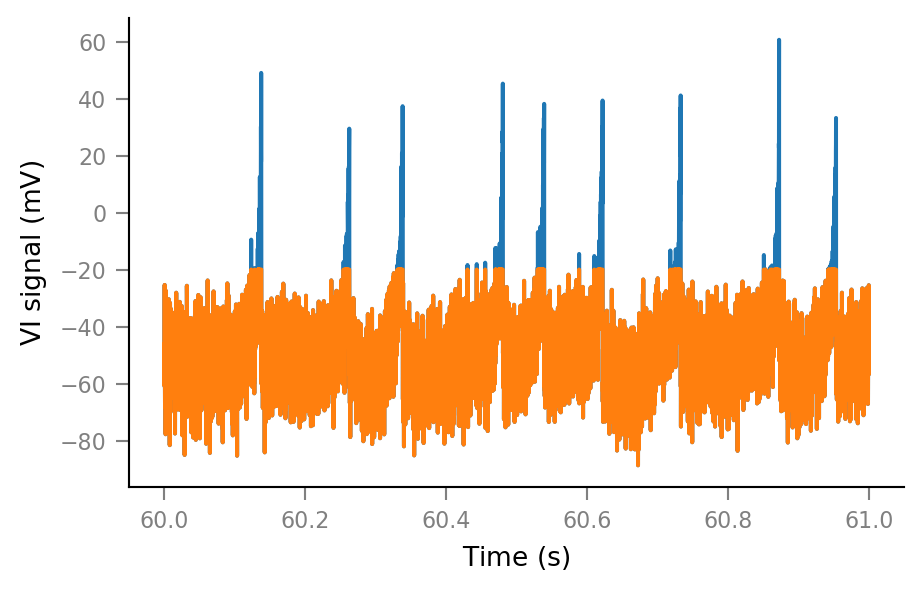

In [21]:
fig, ax = plt.subplots()
ax.plot(t_slice, Vm_noisy[i_slice])
ax.plot(t_slice, Vm_noisy_clipped[i_slice]);

## Spike-triggered windows

In [22]:
def get_spike_indices(spike_train):
    # `nonzero` returns a tuple (one element for each array dimension).
    (spike_indices,) = np.nonzero(spike_train)
    return spike_indices

Extract windows from the VI signal.

In [23]:
window_length = 100 * ms

window_tg = v.TimeGrid(window_length, tg.dt)
window_tg.t.name = "Time after spike"


# Performance
Vm_noisy_clipped_arr = np.asarray(Vm_noisy_clipped)
window_tg_N = window_tg.N
tg_N = tg.N

import numba

@numba.njit
def _make_windows(spike_indices):
    windows = []
    for ix in spike_indices:
        ix_end = ix + window_tg_N
        if ix_end < tg_N:
            windows.append(Vm_noisy_clipped_arr[ix:ix_end])

    return windows

def make_windows(spike_indices):
    windows = np.stack(_make_windows(spike_indices))
    return Array(windows, V, name=Vm_noisy_clipped.name).in_units(mV)

In [28]:
spike_train__example = all_spike_trains[0]
spike_indices__example = get_spike_indices(spike_train__example)
windows__example = make_windows(spike_indices__example)
windows__example.shape

(12019, 1000)

An example spike-triggered window:

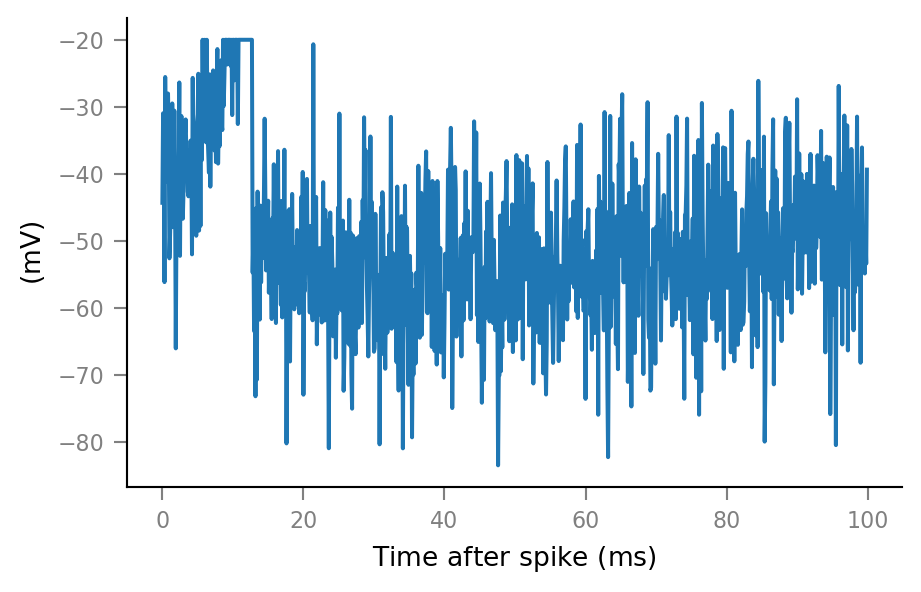

In [29]:
plt.plot(window_tg.t, windows__example[0, :]);

And some more:

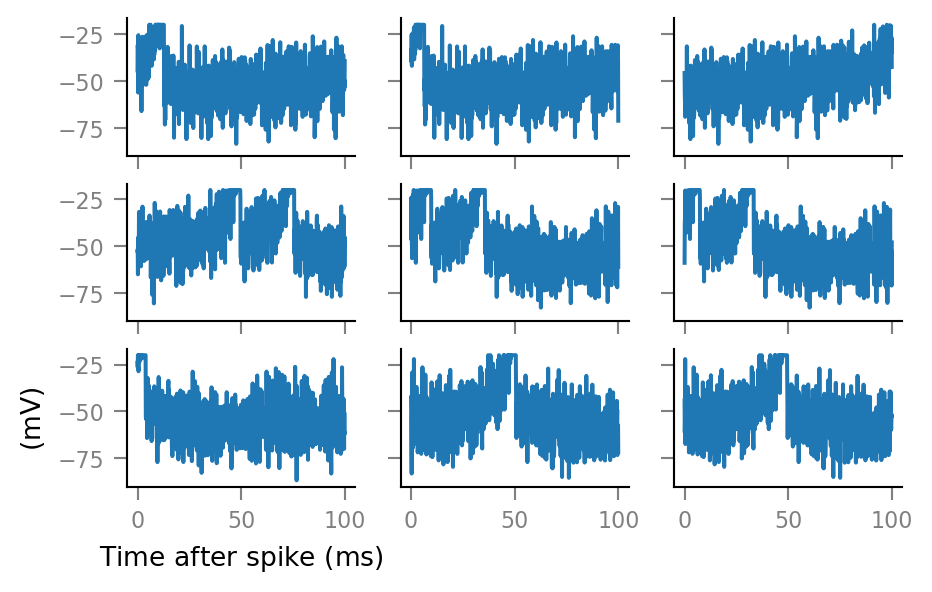

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

for row, row_axes in enumerate(axes):
    for col, ax in enumerate(row_axes):
        i = 3 * row + col
        ax.plot(window_tg.t, windows__example[i, :])
        if not (row == 2 and col == 0):
            ax.set(xlabel=None, ylabel=None)

## Average windows

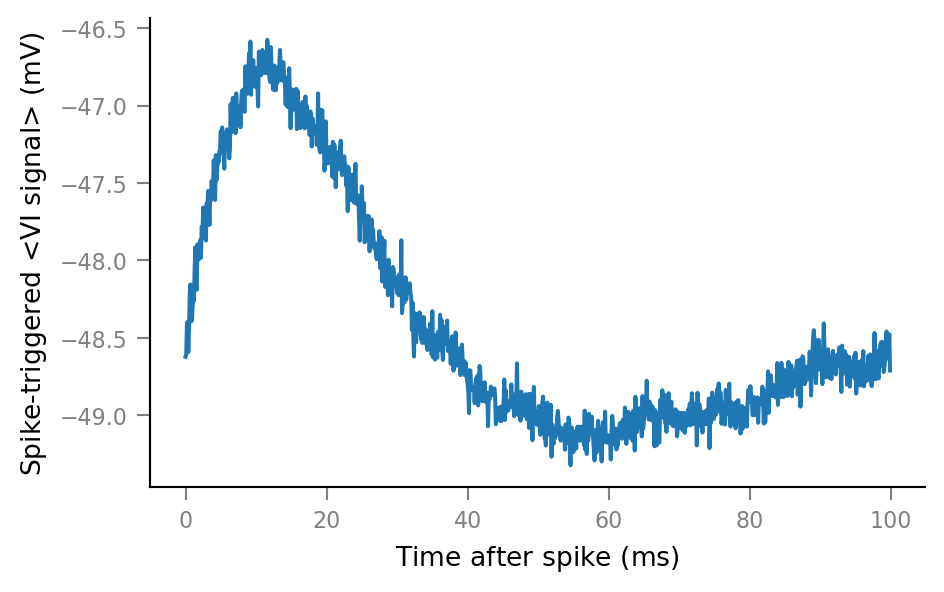

In [31]:
def STA(spike_train):
    spike_indices = get_spike_indices(spike_train)
    windows = make_windows(spike_indices)
    STA = windows.mean(axis=0)
    return Array(STA, V, name="Spike-triggered <VI signal>").in_units(mV)


def plot_STA(spike_train, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(window_tg.t, STA(spike_train), **kwargs)


plot_STA(spike_trains_connected[0])

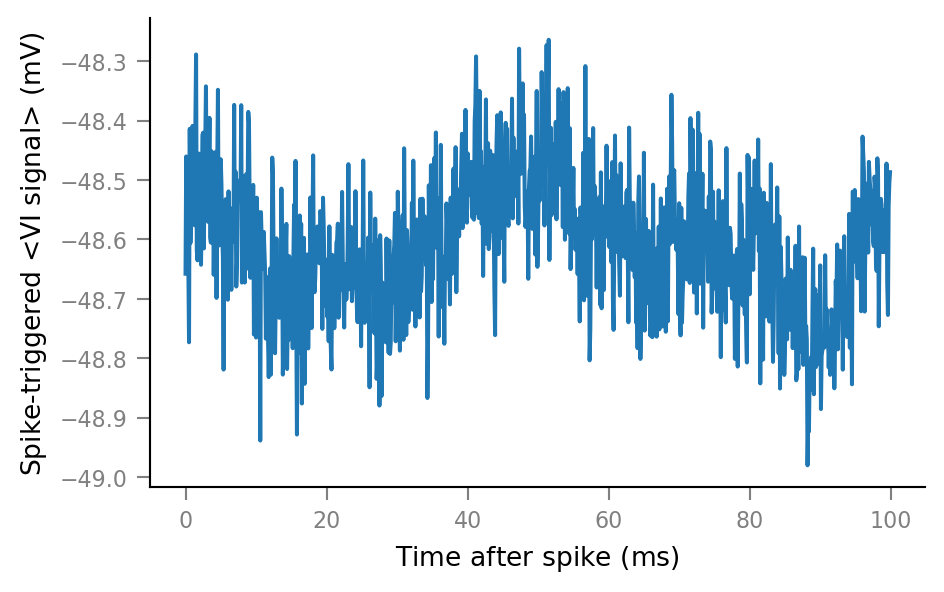

In [32]:
plot_STA(spike_trains_unconnected[0])

## Plot STAs of all spike trains

In [33]:
%%time

fig, ax = plt.subplots()

for spike_train in spike_trains_connected:
    plot_STA(spike_train, ax, alpha=0.2, color='C0')

for spike_train in spike_trains_unconnected:
    plot_STA(spike_train, ax, alpha=0.2, color='C1')
    
plt.close()

Wall time: 31.9 s


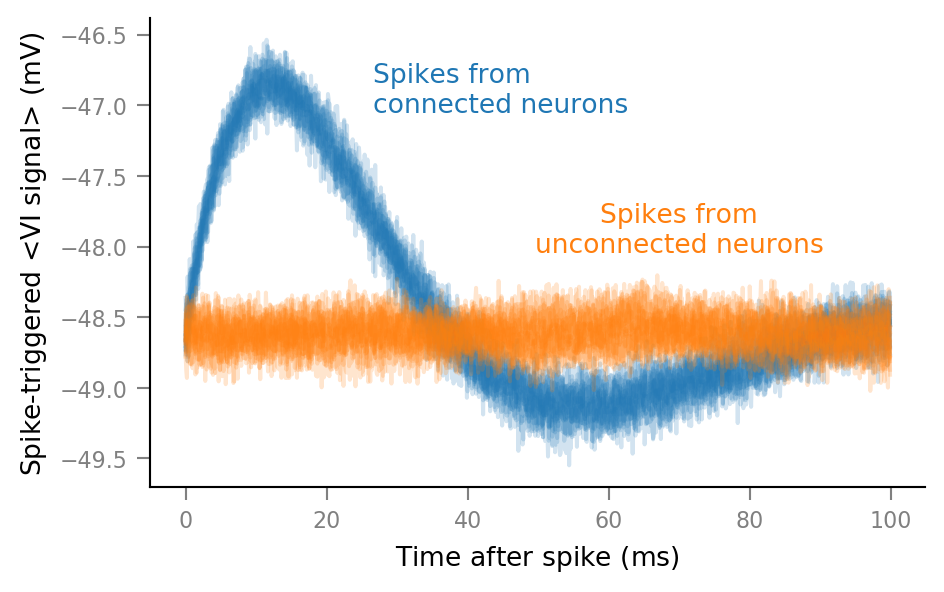

In [34]:
# Clear existing texts, for iterative positioning.
for _ in range(len(ax.texts)):
    ax.texts.pop()

ax.annotate(
    "Spikes from\nconnected neurons",
    xy=(26.55 * ms, 0.8),
    xycoords=("data", "axes fraction"),
    color="C0",
    ha="left",
)

ax.annotate(
    "Spikes from\nunconnected neurons",
    xy=(70 * ms, 0.5),
    xycoords=("data", "axes fraction"),
    color="C1",
    ha="center",
)

fig

This was the first STAs plot, with unclipped spikes (and also with τ_syn = 7 ms):
```{glue:} first_STAs_fig
```

Next steps: 

- calculate p(connected) for every presynaptic neuron
- describe influence of `N_in`, `p_connected`, `SNR`, ..
- VI realism